In [3]:
%pylab inline
import pandas as pd
import numpy as np
import fastai
import torch
from pathlib import Path
import PIL
import tqdm
import os
import json
tqdm.monitor_interval = 0

Populating the interactive namespace from numpy and matplotlib


In [4]:
from fastai.conv_learner import resnet34, resnet152, transforms_top_down, CropType, \
    tfms_from_model, ConvLearner, optim, T
from fastai.dataset import ImageClassifierData, Denormalize
from fastai.sgdr import TrainingPhase, DecayType
from lifelines.utils import concordance_index

In [5]:
def cindex_metric(preds, targs):
    try:
        cindex = concordance_index(preds, targs)
    except:
        cindex = 0.0
    return cindex

In [6]:
torch.backends.cudnn.benchmark=True
torch.cuda.set_device(1)
torch.cuda.current_device()


1

In [11]:
LIVER_PATH = Path('/DATA/BIO/GDC/liver')
LIVER_SAMPLES = LIVER_PATH/"samples"
EXP_PATH = LIVER_PATH/"exp1"
EXP_MODEL_PATH = EXP_PATH/"models"
EXP_DATA = EXP_PATH/"data"
EXP_TRAIN_DATA = EXP_DATA/"train"
EXP_TEST_DATA = EXP_DATA/"test"
PATIENT_JSON = EXP_PATH/'patient_split.json'
TRAIN_CSV = EXP_PATH/'level_1_train.csv'
TRAIN_CSV_FULL = EXP_PATH/'level_1_train_full.csv'
TEST_CSV = EXP_PATH/'level_1_test.csv'
TEST_CSV_FULL = EXP_PATH/'level_1_test_FULL.csv'

for d in [EXP_PATH, EXP_DATA, EXP_TRAIN_DATA, EXP_TEST_DATA, EXP_MODEL_PATH]:
    if not d.exists():
        d.mkdir()

In [12]:
slides = pd.read_csv('../download/slides.csv')
def get_tissue_type(x):
    return x.split('-')[4]

tissue_type = slides.slide_file_name.apply(get_tissue_type)
slides = slides.loc[tissue_type == '01',:].copy()

In [19]:
try:
    with open(PATIENT_JSON, 'r') as fobj:
        patients = json.load(fobj)
        train_patients = patients['train']
        val_patients = patients['val']
        test_patients = patients['test']
    train_slides = slides.loc[slides.submitter_id.isin(train_patients)]
    test_slides = slides.loc[slides.submitter_id.isin(test_patients)]

    train_csv_df = pd.read_csv(TRAIN_CSV_FULL)
    val_idx = train_csv_df.loc[train_csv_df.val_patient].index
except:
    slides['days_proxy'] = slides.days_to_death.fillna(slides.days_to_last_follow_up)
    slides = slides.loc[slides.days_proxy.notnull()].copy()
    patients = random.permutation(list(set(slides.submitter_id)))
    split = int(0.95 * len(patients))
    val_split = int(0.8 * split)
    train_patients = patients[:split]
    val_patients = patients[val_split:split]
    test_patients = patients[split:]

    patient_split = {
        'train': list(train_patients),
        'val': list(val_patients),
        'test': list(test_patients)
    }
    with open(EXP_PATH/'patient_split.json', 'w') as fobj:
        json.dump(patient_split, fobj)

    len(train_patients), len(val_patients), len(test_patients)
    
    train_slides = slides.loc[slides.submitter_id.isin(train_patients)]
    test_slides = slides.loc[slides.submitter_id.isin(test_patients)]
    
    
    train_items = []
    test_items = []
    num_slides = []
    samples_per_slide = 50
    for ix, patient in tqdm.tqdm_notebook(slides.iterrows(), total=len(slides)):
        sfp = LIVER_SAMPLES/patient.slide_file_name.upper()/"level_1"
        sample_files = list(sfp.iterdir())
        num_samples = len(sample_files)
        num_slides.append(num_samples)
        for fn in np.random.choice(sample_files, size=min(samples_per_slide,num_samples), replace=False):
            if patient.submitter_id in train_patients:
                dest_path = EXP_TRAIN_DATA
                train = True
                if patient.submitter_id in val_patients:
                    val = True
                else:
                    val = False
            else:
                dest_path = EXP_TEST_DATA
                train = False

            slide_id = os.path.basename(patient.slide_file_name).split('.')[0]
            img_id = os.path.basename(fn).split('.')[0]
            new_fn_base = '-'.join([slide_id, img_id]) + '.tiff'
            full_path = dest_path/new_fn_base

            if not full_path.exists():
                os.symlink(fn, dest_path/new_fn_base)

            if train:
                train_items.append({
                    'fn': str(new_fn_base),
                    'val': patient.days_proxy,
                    'val_patient': val,
                    'patient_id': patient.submitter_id
                })
            else:
                test_items.append({
                    'fn': str(new_fn_base),
                    'val': patient.days_proxy,
                    'patient_id': patient.submitter_id
                })
                
    train_csv_df = pd.DataFrame(list(random.permutation(train_items)))
    
    train_csv_df[['fn','val']].to_csv(TRAIN_CSV, index=False)
    train_csv_df.to_csv(TRAIN_CSV_FULL, index=False)
    val_idx = train_csv_df.loc[train_csv_df.val_patient].index

    test_csv_df = pd.DataFrame(test_items)
    test_csv_df[['fn','val']].to_csv(TEST_CSV, index=False)
    test_csv_df.to_csv(TEST_CSV_FULL, index=False)

In [20]:
f_model = resnet34
sz=256
bs=16
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, crop_type=CropType.CENTER)
md = ImageClassifierData.from_csv(
    EXP_PATH, "data/train", TRAIN_CSV, tfms=tfms, bs=bs, val_idxs=val_idx, continuous=True
)

md_test = ImageClassifierData.from_csv(
    EXP_PATH, "data/test", TEST_CSV, tfms=tfms, bs=bs, val_idxs=test_csv_df.index, continuous=True
)

In [25]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

/home/fredmonroe/repos/fastai/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [26]:
# set to true to try learning rate finder
if False:
    learn.save('tmp')
    lrf=learn.lr_find()
    learn.sched.plot(0)
    learn.load('tmp')

In [29]:
lr = 1
learn.fit(lr, 4, cycle_len=5, use_clr=(32,5), best_save_name='liver_best_1', metrics=[cindex_metric])
learn.save('liver_1')

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   cindex_metric             
    0      603.002195 800.480971 0.513621  
    1      585.421094 2478.263706 0.538347                 
    2      562.296467 9194.350705 0.538268                 



In [30]:
lr = 0.1
learn.fit(lr, 5, cycle_len=5, use_clr=(32,5), best_save_name='liver_best_2', metrics=[cindex_metric])
learn.save('liver_2')

HBox(children=(IntProgress(value=0, description='Epoch', max=25), HTML(value='')))

epoch      trn_loss   val_loss   cindex_metric             
    0      551.554762 22306.19503 0.533114  
    1      561.991755 3249.970818 0.536006                 
    2      558.707892 4947.480091 0.541625                 
    3      533.588561 11863.24019 0.540837                 
    4      538.884717 4257.014944 0.540677                 
    5      556.945806 3307.84435 0.541895                  
    6      544.479282 1678.641691 0.539446                 
    7      544.092819 2677.026327 0.54445                  
    8      554.477637 1457.640576 0.543842                 
    9      543.793081 838.723055 0.544539                  
    10     542.542939 2152.263631 0.541781                 
    11     549.691347 2707.210244 0.541192                 
    12     544.490882 572.086199 0.54222                   
    13     545.59784  11114.520217 0.545205                
    14     545.978016 2184.417394 0.546192                 
    15     549.086834 3157.682395 0.542966             

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
lr = 0.01
learn.fit(lr, 20, cycle_len=5, use_clr=(32,5), best_save_name='liver_best_3', metrics=[cindex_metric])
learn.save('liver_3')

HBox(children=(IntProgress(value=0, description='Epoch'), HTML(value='')))

epoch      trn_loss   val_loss   cindex_metric             
    0      548.186578 1509.549918 0.549685  
    1      537.366973 1490.522408 0.549524                 
    2      546.453126 2955.044755 0.549019                 
    3      544.846399 4976.962902 0.55018                  
    4      531.532194 3072.78719 0.549287                  
 39%|███▉      | 108/276 [00:16<00:25,  6.55it/s, loss=537]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    18     546.536333 8736.088889 0.552171                 
    19     539.992203 2961.616533 0.551824                 
    20     525.109199 1841.075263 0.553065                 
    21     537.418972 2841.226772 0.5532                   
    22     535.331294 650.487131 0.553758                  
 73%|███████▎  | 201/276 [00:29<00:11,  6.72it/s, loss=524]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    36     530.941138 2314.774708 0.554468                 
    37     531.380823 1057.580442 0.553101                 
    38     526.461036 6737.829406 0.55179                  
    39     521.682113 613.774312 0.553219                  
    40     523.855915 8926.949837 0.553691                 
 83%|████████▎ | 230/276 [00:34<00:06,  6.76it/s, loss=542]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    54     524.859027 4800.732614 0.556392                 
    55     516.348416 5294.322077 0.555997                 
    56     528.233206 5723.134182 0.556007                 
    57     544.068859 761.616477 0.55565                   
    58     529.325719 837.299875 0.555614                  
    59     532.074066 951.784065 0.557648                  
  2%|▏         | 5/276 [00:01<01:36,  2.80it/s, loss=530]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    72     521.893009 831.945382 0.557532                  
    73     526.927372 2724.213276 0.558199                 
    74     535.246683 768.349073 0.557966                  
    75     524.061324 626.231605 0.556747                  
    76     536.626489 845.429391 0.557405                  
    77     518.003369 1235.820839 0.557966                 
 18%|█▊        | 49/276 [00:07<00:35,  6.34it/s, loss=533]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    91     545.994536 824.215958 0.562581                  
    92     525.171862 792.05211  0.561143                  
    93     527.547871 600.209535 0.559371                  
    94     509.504974 645.038302 0.560644                  
    95     533.764349 708.448046 0.561507                  
 42%|████▏     | 116/276 [00:17<00:24,  6.52it/s, loss=521]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
lrs = np.array([lr/100, lr/10, lr])
learn.freeze_to(-2)
learn.fit(lrs, 10, cycle_len=10, use_clr=(32,10), best_save_name='liver_best_4', metrics=[cindex_metric])
learn.save('liver_4')

HBox(children=(IntProgress(value=0, description='Epoch'), HTML(value='')))

epoch      trn_loss   val_loss   cindex_metric             
    0      557.441113 3738.753223 0.53385   
    1      538.927193 7607.744861 0.545522                 
    2      541.59516  12303.387441 0.550914                
    3      518.73888  31861.259616 0.571591                
    4      494.946207 603.233637 0.569304                  
 39%|███▉      | 107/276 [00:23<00:37,  4.48it/s, loss=506]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    18     345.823824 7519.791252 0.667039                 
    19     343.730241 127174.772511 0.675058               
    20     401.277261 10156.132758 0.632756                
    21     404.779356 1224.485397 0.6218                   
    22     406.08545  31786.274435 0.616091                
 54%|█████▍    | 150/276 [00:32<00:27,  4.62it/s, loss=380]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    36     282.457317 4566.594483 0.703808                 
    37     264.230692 10328.52242 0.710643                 
    38     251.444274 753.131528 0.719796                  
    39     237.822007 598.275967 0.725104                  
    40     306.608605 1293.671853 0.674151                 
 58%|█████▊    | 159/276 [00:34<00:25,  4.57it/s, loss=312]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    54     244.055937 239.193515 0.716997                  
    55     230.371757 2306.561392 0.725472                 
    56     212.615087 203.065352 0.742438                  
    57     199.839276 425.021142 0.737038                  
    58     193.045923 331.65708  0.749585                  
 67%|██████▋   | 185/276 [00:40<00:19,  4.55it/s, loss=183]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    72     244.590292 224.935869 0.723588                  
    73     208.570241 250.708579 0.738775                  
    74     204.469009 201.863837 0.748692                  
    75     189.804977 225.643422 0.756993                  
    76     174.902257 185.832887 0.759915                  
 83%|████████▎ | 229/276 [00:49<00:10,  4.60it/s, loss=164]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    90     187.818144 211.469999 0.729577                  
    91     221.728876 3125.388185 0.738992                 
    92     213.444377 695.947882 0.744216                  
    93     196.631751 181.102764 0.755527                  
    94     171.744613 197.592143 0.761399                  
    95     168.651694 777.69499  0.758081                  
  0%|          | 1/276 [00:01<04:57,  1.08s/it, loss=169]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [66]:
lrs = np.array([lr/100, lr/10, lr])
learn.freeze_to(-2)
learn.fit(lrs, 1, cycle_len=10, use_clr=(32,10), best_save_name='liver_best_5', metrics=[cindex_metric])
learn.save('liver_5')

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   cindex_metric             
    0      174.981989 209.116802 0.743673  
    1      193.999884 216.696528 0.755679                  
    2      174.133351 174.831888 0.759622                  
    3      166.915496 163.193418 0.767542                  
    4      176.259088 163.771943 0.759412                  
    5      155.261857 939.851968 0.770377                  
    6      151.961062 133.097705 0.778853                  
    7      138.630279 133.703139 0.780801                  
    8      129.787115 237.492949 0.782897                  
    9      130.055211 117.720141 0.78833                   



In [33]:
def eval_model(learn, model_name):
    learn.save('tmp')
    learn.load(model_name)
    y_pred, y_targ = learn.predict_with_targs()
    learn.load('tmp')
    return learn.crit(T(y_pred), T(y_targ)), cindex_metric(y_pred, y_targ)

In [67]:
for mname in ['liver_1', 'liver_best_1', 
              'liver_2', 'liver_best_2', 
              'liver_3', 'liver_best_3', 
              'liver_4', 'liver_best_4',
              'liver_5', 'liver_best_5'
             ]:
    print(mname,eval_model(learn, mname))

liver_1 (tensor(9194.3516, device='cuda:1'), 0.5708342592520156)
liver_best_1 (tensor(2478.2639, device='cuda:1'), 0.5632086847420128)
liver_2 (tensor(683.5911, device='cuda:1'), 0.6008112319710077)
liver_best_2 (tensor(683.5911, device='cuda:1'), 0.6008112319710077)
liver_3 (tensor(5451.8164, device='cuda:1'), 0.6135976417987639)
liver_best_3 (tensor(824.2160, device='cuda:1'), 0.6155594617401238)
liver_4 (tensor(315.7702, device='cuda:1'), 0.9002067749972144)
liver_best_4 (tensor(315.7702, device='cuda:1'), 0.9002067749972144)
liver_5 (tensor(117.7201, device='cuda:1'), 0.9093368441773476)
liver_best_5 (tensor(117.7201, device='cuda:1'), 0.9093368441773476)


In [68]:
learn.load('liver_best_5')

In [69]:
y_pred = learn.predict_dl(md_test.val_dl)
y_pred.shape, test_df.shape

((1450, 1), (1450, 4))

In [70]:
test_df = test_csv_df.copy()
test_df['y_pred'] = y_pred

In [71]:
yp_pred = test_df.groupby('patient_id').y_pred.min()
yp_targ = test_df.groupby('patient_id').val.mean()

In [72]:
concordance_index(yp_pred, yp_targ )

0.49707602339181284

In [73]:
learn.crit(T(yp_pred), T(yp_targ))

tensor(1032.8519, device='cuda:1')

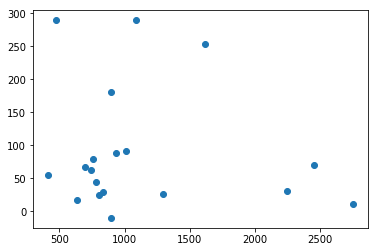

In [74]:
scatter(yp_targ, yp_pred)

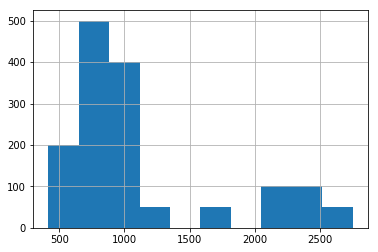

In [75]:
test_df.val.hist()

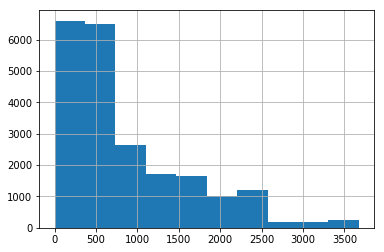

In [77]:
train_csv_df.val.hist()